Xuất phát từ thực tế là 1 bức ảnh có nhiều chi tiết thừa. Xem xét bức ảnh sau đây:

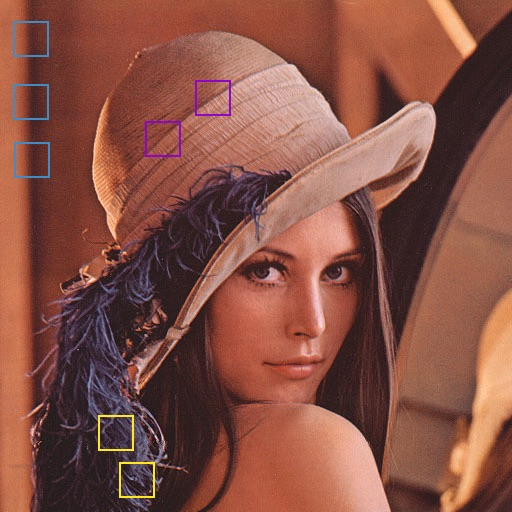

Các hình vuông cùng màu nằm trên các khu vực tương tự. Vậy tại sao không sử dụng tất cả những thông tin này để suy ra giá trị của các pixel. Ý tưởng xuất phát từ lý thuyết Trường ngẫu nhiên Markov Random Field, theo trực giác, cho cho rằng vùng lân cận của một pixel sẽ tương tự đối với các vùng lân cận tương tự.

Về cơ bản, thuật toán sửa đổi từng giá trị pixel theo giá trị trung bình có trọng số của tất cả các pixel khác và các giá trị trọng số được xác định bởi độ tương đồng vùng lân cận:

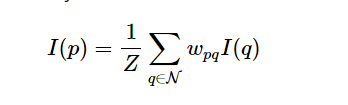


Biến $Z = \sum w_{pq}$ là hệ số chuẩn hóa và $\cal{N}$ là vùng lân cận xung quanh pixel $p$. Trọng số $w_{pq}$ được tính như sau:

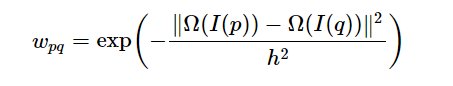

trong đó $\Omega(p)$ chỉ ra một cửa sổ tâm pixel $p$. Dịch sang mã giả, ta có như sau:


for x,y in Image:

    total_color = 0
    Z = 0

    for xp,yp in BigNeighborhood(x,y):
        difference = norm(SmallNeighborhood(x,y) - SmallNeighborhood(xp,yp))
        w = exp(-difference/h^2)
        total_color = total_color + w*I(xp, yp)
        
    I(x,y) = color / Z

In [ ]:
#import các thư viện cần thiết
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
from skimage import data_dir
from skimage.transform import resize
import time

In [ ]:
#load hình ảnh và khởi tạo nhiễu gauss
noise_var = np.logspace(0, 2, 5)
data_dir = '/content/drive/MyDrive/TEST'
lena = io.ImageCollection(data_dir + "/lena.png")[0].astype(np.float) / 255.0
#giảm chiều dữ liệu
lena = resize(lena, (lena.shape[0]/2, lena.shape[1]/2, lena.shape[2] - 1))
#chuyển hệ màu sang hệ lab 
lena = color.rgb2lab(lena)

lena = lena[:,:,0]

noisy = []
for sigma2 in noise_var:
  #khởi tạo nhiễu gauss
  #Nhiễu này có được do bản chất rời rạc của bức xạ (hệ thống ghi ảnh bằng cách đếm các photon (lượng tử ánh sáng). Mỗi pixel trong ảnh nhiễu là tổng giá trị pixel đúng và pixel ngẫu nhiên .
    noise = np.random.normal(0, np.sqrt(sigma2), lena.shape)

    n = lena + noise
    #tránh truờng hợp overbound
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)
  

(256, 256, 3)
(256, 256)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


**ĐO CHẤT LƯỢNG HÌNH ẢNH**

Chúng ta cần một thước đo để đo hiệu suất của thuật toán. Ở đây chúng ta sử dụng PSNR (Tỉ số tín hiệu cực đại trên nhiễu)

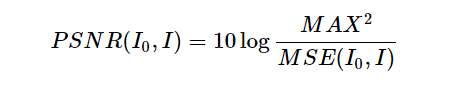

Trong đó $ I_0 $ là hình ảnh ban đầu của chúng ta và $ I $ là hình ảnh bị biến dạng. $ MAX $ là giá trị tối đa mà tín hiệu có thể nhận được. 

In [ ]:
def PSNR(original, noisy, peak=100):
    mse = np.mean((original-noisy)**2)
    return 10*np.log10(peak*peak/mse)

Dưới đây là một số hình ảnh với lượng nhiễu khác nhau:

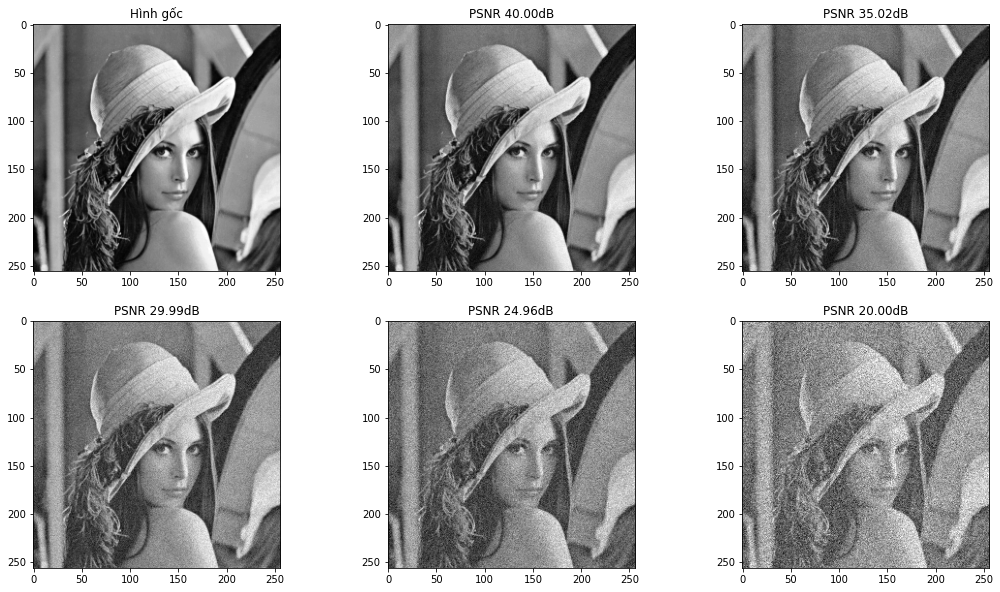

In [ ]:
#show hình ảnh có nhiễu
plt.figure(figsize=(18,10)) 

plt.subplot(2,3,1)
plt.imshow(lena,cmap='gray')
plt.title("Hình gốc")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.2f}dB".format(PSNR(lena, n)))
    plt.imshow(n,cmap='gray')

Hình ảnh có PSNR càng cao thì hình ảnh càng chất lượng hơn

**Cách tiếp cận ngây thơ**

Theo định nghĩa thuật toán, chúng ta có thể dịch trực tiếp các phép toán trong thuật toán NLM thành code, bằng cách:

- Lặp từng pixel $p$

- Với mỗi $p$ tiếp tục lặp tất cả pixel $q$ để so sánh patch
- Tính từng patch tâm $q$ thành patch tâm $p$
- Tính trọng số từng patch phù hợp và tính giá trị trung bình trọng số

Có một vấn đề lớn với cách tiếp cận này: thời gian chạy. Với hình ảnh kích thước $N\times M$, cách tiếp cận này có độ phức tạp thời gian $O(N^4D^2)$ trong đó $D$ là chiều rộng của các patch chúng ta đang so sánh. Rõ ràng cách này thậm chí không khả thi với các hình ảnh có kích thước trung bình.

Một giải pháp đơn giản là giới hạn không gian tìm kiếm trên $q$ và thay vì lặp qua toàn bộ hình ảnh, chỉ cần tìm các patch tương tự với kích thước $W$. Sau đó thuật toán có độ phức tạp thời gian $O(N^2W^2D^2)$ không quá tệ, nhưng nó vẫn tốn thời gian cho việc xử lý ảnh.
Sau đây là cách tiếp cận ngây thơ:

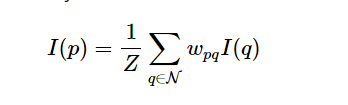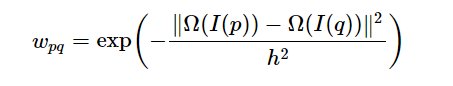

Thuật toán NLM được nhận input:

- Hình ảnh chúng ta muốn denoise.
- Một kernel kích thước k x k k.
- Một cửa sổ kích thước w x w w.

Đối với mỗi pixel trong hình ảnh (mà chúng ta sẽ denoise) chúng ta tập trung vào cửa sổ xung quanh nó, thường là cửa sổ khá lớn nhưng tất nhiên không lớn như toàn bộ hình ảnh vì lý do hiệu suất. Sau đó, đối với mỗi pixel trong cửa sổ, chúng ta trượt patch (thường là 3x3 hoặc 5x5) và pixel mà chúng ta muốn denoise sẽ là một tổng trọng số trên các patch của hình ảnh.

In [ ]:
from functools import reduce, partial

def _distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values
    
    diff = np.sum((pixel_window - patch_window) ** 2)
    #xóa khoảng cách tâm khỏi phép tính
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    #trả về màu sắc của pixel và trọng số`
    nr, nc = patch_window.shape
    return w * patch_window[nr // 2, nc // 2], w

def nonlocalmeans_naive(img, n_big=20, n_small=5, h=10):
    #new_n = 0 
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    #h^2
    h2 = h * h
    n_rows, n_cols = img.shape

    #tính toán trước sự khác biệt tọa độ cho patch lớn
    
    D = range(-n_big, n_big + 1)
    
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    #tính toán trước sự khác biệt tọa độ cho patch nhỏ (tạo patch)
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            #xây dựng danh sách các cửa sổ patch
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            #xây dựng danh sách các tâm khác biệt
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c / total_w

    return new_n

**Ước tính nhiễu**

Chúng ta đã có tất cả thứ cần dùng để khử nhiễu ảnh bằng NLM. Nhưng chúng ta vẫn chưa hiểu về những tham số. Tại sao n_big = 20, n_small = 5 và h = 10? Đây là giải thích và một vài cải tiến.

n_big: liên quan đến vùng lân cận lớn để tìm kiếm patch. Càng lớn, càng tốt nhưng càng tiêu tốn nhiều tài nguyên CPU.

n_small: liên quan đến kích thước patch khi so sánh lân cận tương tự. Chúng ta không thể chọn patch quá lớn vì các patch sẽ khác nhau, chúng ta cũng không thể chọn patch quá nhỏ vì các patch sẽ giống nhau. Chúng ta thường chọn từ 3 đến 10.

h: đây là hằng số sử dụng để kiểm soát sự khác biệt giữa các patch. Nó có liên quan chặt chẽ đến phương sai nhiễu $\sigma^2$ hiện diện trên hình ảnh, và nó có thể phụ thuộc từ pixel này sang pixel khác. Thông thường nó bằng $K\sigma$ trong đó K is $(7,10)$.

Bộ lọc thông thấp (lọc cắt đi phần cao)

Tất nhiên, ở đây chúng ta biết được lượng nhiễu trên mỗi hình ảnh, nhưng thông thường thì không như vậy. Tuy nhiên chúng ta có thể ước tính nhiễu thô $\widehat{\sigma}$ bằng cách cố gắng dự đoán bộ lọc thông thấp tuyến tính tối ưu để giảm thiểu sai số bình phương. Vì chúng ta biết được rằng bộ lọc thông thấp tuyến tính sẽ xem tần số cao là nhiễu và do đó $\widehat{\sigma} > \sigma$, chúng ta sẽ cho $h=2*\widehat{\sigma}$.

Sau đây là code để ước tính $\widehat{\sigma}$ sử dụng hồi quy tuyến tính:

In [ ]:
def estimate_noise(img):
    #bỏ 2 dòng cuối và các phần tử trái phải ma trận
    upper = img[:-2, 1:-1].flatten()
    #bỏ 2 dòng đầu và các phần tử trái phải ma trận
    lower = img[2:, 1:-1].flatten()
    #bỏ 2 cột cuối và các phần tử trên dưới ma trận
    left = img[1:-1, :-2].flatten()
    #bỏ 2 cột đầu và các phần tử trên dưới ma trận
    right = img[1:-1, 2:].flatten()
    #bỏ các phần tử trái phải trên dưới ma trận
    central = img[1:-1, 1:-1].flatten()
    #Xây dựng lại hình ảnh
    U = np.column_stack((upper, lower, left, right))
    #linalg.pin: giả nghịch đảo Moore-Penrose
    c_estimated = np.dot(U, np.dot(np.linalg.pinv(U), central))
    #mean square error
    error = np.mean((central - c_estimated)**2)
    sigma = np.sqrt(error)
    return sigma

In [ ]:
sigmas = []
for i,n in enumerate(noisy):
    sigma = estimate_noise(n)
    sigmas.append(sigma)
    print("Estimated noise is {0:.4f}, real noise is {1:.4f}".format(sigma, np.sqrt(noise_var[i])))
    

Estimated noise is 2.0682, real noise is 1.0000
Estimated noise is 2.6580, real noise is 1.7783
Estimated noise is 3.9747, real noise is 3.1623
Estimated noise is 6.5816, real noise is 5.6234
Estimated noise is 11.3806, real noise is 10.0000


PSNR before 39.9975 - PSNR after denoising 36.3892 - took 256.8 secs
PSNR before 35.0055 - PSNR after denoising 35.1906 - took 256.4 secs
PSNR before 29.9862 - PSNR after denoising 33.3144 - took 255.7 secs
PSNR before 25.0292 - PSNR after denoising 30.7072 - took 255.7 secs
PSNR before 20.0414 - PSNR after denoising 27.8310 - took 255.6 secs


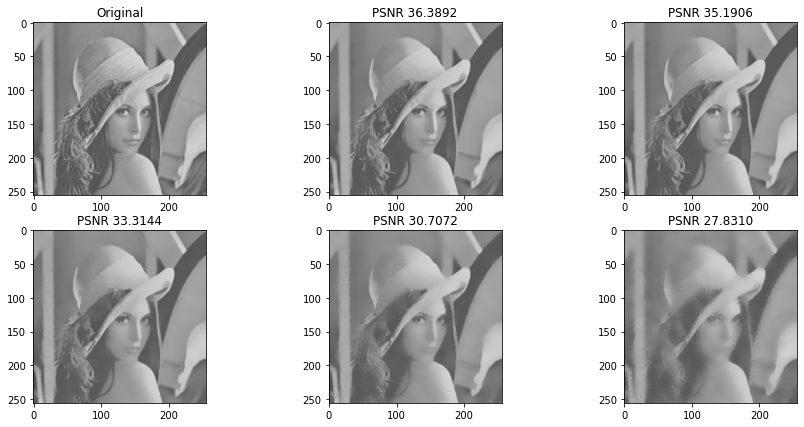

In [ ]:
denoised_naive = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_naive(noisy[2], n_big=7, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena, noisy[i])
    dPSNR = PSNR(lena, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - took {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')